<img src="https://www.ryanlarose.com/uploads/1/1/5/8/115879647/banner.png">

# Tutorial 3: Superconducting Qubits, Noise, and Decoherence

<img src="https://www.researchgate.net/profile/Graham_Smetham/publication/268052917/figure/download/fig14/AS:668771421286410@1536458940555/Zureks-cartoon-the-two-truths-quantum-and-classical.jpg">

Many different physical systems can realize quantum bits. Among them, superconducting qubits are a current top contendor. This notebook serves as a tutorial for superconducting qubits in particular, but many concepts apply to the general qubit. We look in detail at *energy dissipation* and *decoherence* (or, the quantum-to-classical transition).

## Learning goals

(1) Understand how microwave pulses can manipulate superconducting qubits.

(2) Visualize pulse sequences using Qiskit.

(3) Be able to define T1 and T2 times, and set up an experiment to measure them.

(4) Perform data-fitting to measure T1 and T2 times on IBM quantum devices.

In [1]:
"""Imports."""
import matplotlib.pyplot as plt
import numpy as np
import scipy as scp

from IPython.display import clear_output, display

import qiskit.pulse as pulse
import qiskit

In [2]:
"""Plotting style."""
%matplotlib inline
plt.rcParams.update({"font.size": 16, "font.weight": "bold"})

## How to manipulate qubits with pulses

This section is fairly technical. Those with appropriate background (at least quantum mechanics) will gain a working understanding of how qubits are manipulated; those without such a background will likely not benefit from this section. For the latter, you can skip to the next section with the following message:

**Big picture takeaway:** We perform quantum gates on superconducting qubits by sending microwave pulses through control lines.

### The Qubit Hamiltonian

*Note: This section gives a brief exposition. More details can be found in Section III of this [paper](https://arxiv.org/abs/1904.06560).*

<img src="https://www.laboratory-journal.com/sites/git-labor.de/files/images/special/53067172__original.jpg" style="width:400px;height:300px;">

Like most things in physics, our starting point is a harmonic oscillator. Using Kirchoff's laws and circuit quantization techniques, one can quantize the classical LC circuit Hamiltonian to arrive at the **qubit Hamiltonian** 

\begin{equation}
    H = - \frac{\omega_q}{2} \sigma_{z} + \Omega V_d(t) \sigma_{y} .
\end{equation}

Here, $\omega_q$ (the **qubit frequency**) and $\Omega$ are determined by parameters of the circuit (e.g., capicatance and inductance). The variable $V_d(t)$ is called the **drive voltage**. It is the time-dependent quantity that we vary to implement gates on the qubit. As usual, the $\sigma$'s are Paulis

\begin{equation}
    \sigma_{x} := \left[ \begin{matrix}
    0 & 1 \\
    1 & 0 \\
    \end{matrix} \right]
    \qquad
    \text{and}
    \qquad
    \sigma_{y} := \left[ \begin{matrix}
    0 & -i \\
    i & 0 \\
    \end{matrix} \right]
    \qquad
    \text{and}
    \qquad
    \sigma_{z} := \left[ \begin{matrix}
    1 & 0 \\
    0 & -1 \\
    \end{matrix} \right] .
\end{equation}

### The drive Hamiltonian

In the *rotating frame*, the **drive Hamiltonian** (second term in the qubit Hamiltonian) can be written

\begin{equation}
    \tilde{H}_d = \Omega V_d(t) \left[ \cos (\omega_q t) \sigma_y - \sin(\omega_q t) \sigma_x \right]
\end{equation}

Writing (without loss of generality) $V_d(t) = V_0 s(t) \left[ \cos( \phi ) \sin(\omega_d t) + \sin(\phi) \cos (\omega_d t) \right]$ and defining

\begin{align}
I &:= \cos (\phi) \qquad \text{(the "in-phase" component)} \\
Q &:= \sin (\phi) \qquad \text{(the "out-of-phase" component)}
\end{align}

e can write the drive Hamiltonian (using the rotating wave approximation) as

\begin{equation}
    \tilde{H}_d = - \frac{\Omega}{2} V_0 s(t) \left[ \begin{matrix}
    0 & e^{i (\delta\omega t + \phi)} \\
    e^{-i (\delta\omega t + \phi)} & 0 \\
    \end{matrix} \right]
\end{equation}

where $\delta\omega := \omega_q - \omega_d$, i.e., the difference between the qubit and drive frequencies. *This is **the equation** for understanding single qubit gates.*

### Implementing single qubit gates

**Question:** Show that if we apply a pulse at the qubit frequency, i.e., $\delta\omega = 0$, then

\begin{equation}
    \tilde{H}_d = - \frac{\Omega}{2} V_0 s(t)( I \phi_x + Q \sigma_y) .
\end{equation}

<font size=8 color="#009600">&#9998;</font> **Answer:** Answer the above question here!

Thus, for a pulse at the qubit frequency, an *in-phase pulse* ($\phi = 0 \implies Q = 0$) corresponds to rotating the qubit about the $x$-axis. Similarly, an *out-of-phase pulse* ($\phi = \pi / 2 \implies I = 0$) corresponds to rotating the qubit about the $y$-axis. 

How long should we apply the pulse for? Solving Schrodinger's equation with, for example, the in-phase pulse above, we have

\begin{equation}
    U(t) = \exp \left ( \left[ \frac{i}{2} \Omega V_0 \int_{0}^{t} s(t') \, dt' \right] \sigma_x \right) 
\end{equation}

One can see this is the standard form of an $x$-rotation with angle

\begin{equation}
    \Theta(t) := - \Omega V_0 \int_{0}^{t} s(t') \, dt'
\end{equation}

If we want to rotate by, say, $\pi / 2$ radians about the $x$-axis, we thus solve the equation $\Theta(t) = \pi / 2$ for time $t$. This then tells us how long to apply the pulse. 

**Question**: Suppose $s(t) = - t$. (Please don't ask what waveform generator does... this I'm a theorist.) How long should we apply an in-phase pulse to implement a NOT gate: i.e., a rotation about the $x$-axis by $\pi / 2$ radians. Express your answer in terms of $\Omega$ and $V_0$. 

<font size=8 color="#009600">&#9998;</font> **Answer:** Answer the above question here!

## Pulse sequences in Qiskit

Qiskit has a module called `Pulse` for creating pulse sequences and manipulating qubits at a lower level than the standard gates provided in Qiskit. Unfortunately, we could not get access to `Pulse` for the bootcamp, but we can still examine its functionality to help us better understand superconducting qubits. You can read the [documentation for Pulse here](https://qiskit.org/documentation/apidoc/pulse/pulse.html). Specifically, we will analyze at pulse schedules and the data generated by pulse schedules to calibrate and measure superconducting qubits. 

If we had access to the `ibmq-poughkeepsie` device (which is necessary to use `Pulse`), we would run the following cells to setup `Pulse`. 

In [3]:
"""Load account: Only do this once."""
qiskit.IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
"""Get a provider and see available backends."""
provider = qiskit.IBMQ.get_provider(hub="ibm-q")
print("Available backends:", *provider.backends())

Available backends: ibmq_qasm_simulator ibmqx2 ibmq_16_melbourne ibmq_vigo ibmq_ourense


You can only use `Pulse` if you see the `ibmq-poughkeepsie` backend, which no users will by default. This requires access to a "hub" which can use `Poughkeepsie`. 

In [6]:
"""Select a backend."""
# backend = provider.get_backend("ibmq_poughkeepsie")
# config = backend.configuration()
# defaults = backend.defaults()

'Select a backend.'

In [7]:
"""Get a pulse channel system."""
# system = pulse.PulseChannelSpec.from_backend(backend)

'Get a pulse channel system.'

I guess I'll just import pictures of pulse schedules here...

## Evaluating qubits: Measuring frequency, T1, and T2 times

Now that we understand pulses, we can use them to investigate properties of qubits. The three properties we will investigate are **qubit frequency**, **energy dissipation**, and **decoherence**. We were already introduced to qubit frequency above: it is simply the frequency $\omega_q := f_q / 2 \pi$ of the qubit, or equivalently its energy $E_q = \hbar \omega_q$. We will first determine the frequency of a qubit, then measure energy dissipation and decoherence.

## Energy dissipation and T1

The state $|0\rangle$ is the ground state of the qubit, and the state $|1\rangle$ is the excited state, meaning the qubit has more energy in this state. Due to environmental interactions (e.g., exchanging energy with a photon), a qubit in the $|1\rangle$ state will lose energy and eventually "decay" into the ground state. Experimentally, this decay follows an exponential curve with exponent proportional to $1 / T_1$. 

Explicitly, the probability of finding an excited qubit in the ground state after time $t$ is found to be

$$ p_0(t) = e^{ - t / T_1 } $$ 

### How to measure T1

The definition of T1 suggests a simple way to measure it.

1. Put the qubit in the $|1\rangle$ (excited) state.
1. Wait a time $t$.
1. Measure the qubit.

This is exactly how T1 times are measured in the lab. We can do the same with Qiskit.

### Pulse sequence

The pulse sequence for measuring T1 simply translates the above pseudocode. We apply an in-phase $\pi$-pulse at the qubit frequency to excite it from $|0\rangle$ to $|1\rangle$. Then we wait for a time $t$ and finally apply a measurement pulse. The entire pulse sequence is shown in the diagram below.

### Raw data

In [15]:
"""Load in the raw data."""
T1real = 50  # microseconds
sigma = 5.0
times = np.linspace(0, 100, 1000)
data = np.exp(- times / T1real) + np.random.randn(len(times)) / sigma**2

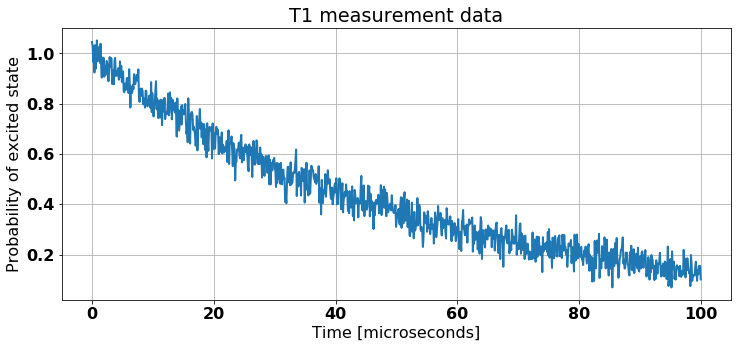

In [16]:
"""Plot the raw data."""
plt.figure(figsize=(12, 5))
plt.plot(times, data, linewidth=2);
plt.xlabel("Time [microseconds]");
plt.ylabel("Probability of excited state");
plt.title("T1 measurement data")
plt.grid();
plt.show()

### Fitting

In [17]:
"""Do the data fitting."""
def fit(time: float, T1: float) -> float:
    return np.exp(-time / T1)  # Your code here!

In [21]:
"""Use scipy.optimize.curve_fit to fit the data."""
optimal_params, covariance = scp.optimize.curve_fit(fit, times, data)
print(f"Computed T1 value: {round(optimal_params[0], 3)} microseconds.")

Computed T1 value: 49.895 microseconds.


**Question:** What is your computed $T_1$ time? (Remember units!)

<font size=8 color="#009600">&#9998;</font> **Answer:** Answer the above question here!

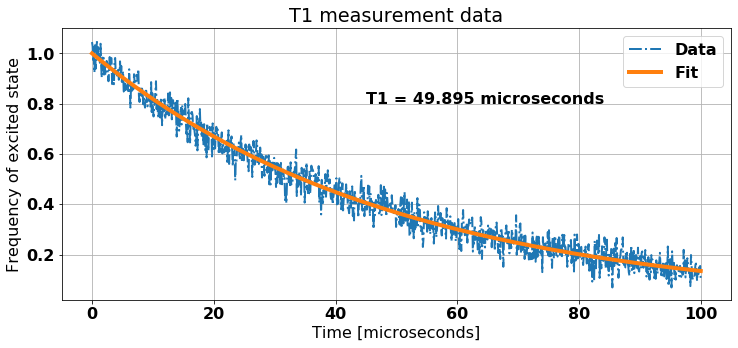

In [22]:
"""Plot your fit over the raw data here."""
# Compute the fit
fitvals = fit(times, *optimal_params)

# Plot the fit and data
plt.figure(figsize=(12, 5))
plt.plot(times, data, "-.", linewidth=2, label="Data");
plt.plot(times, fitvals, "-", linewidth=4, label="Fit");
plt.xlabel("Time [microseconds]");
plt.ylabel("Frequency of excited state");
plt.title("T1 measurement data");
plt.legend();
plt.grid();
plt.text(45, 0.8, f"T1 = {round(optimal_params[0], 3)} microseconds")
plt.show()

**Question**: Search online for IBMQ devices. What are typical T1 values for other qubits and devices? (This [link](https://github.com/Qiskit/ibmq-device-information) may be useful.)

<font size=8 color="#009600">&#9998;</font> **Answer:** Answer the above question here!

## Measure T2 time

When qubits interact with their environment, they lose more than just energy. **Coherence**, a defining feature of quantum mechanics and departure from the classical world, is the ability for "particles" to exist in a superposition of (basis) states. For a single qubit, a coherent state can thus be written

\begin{equation}
    |\psi\rangle = \alpha |0\rangle + \beta |1\rangle .
\end{equation}

In the density matrix formalism, we may equivalently write

\begin{equation}
    \rho \equiv |\psi\rangle \langle \psi| = \left[ \begin{matrix} 
     |\alpha|^2 & \alpha \beta^* \\
     \alpha^* \beta & |\beta|^2 
    \end{matrix} \right]
\end{equation}

Note that the superposition is directly responsible for the off-diagonal terms in this matrix.

**Question:** Show that the density matrix of $|\psi\rangle = |0\rangle$ has off-diagonal elements equal to zero. In particular, show that the density matrix is

\begin{equation}
    \rho \equiv |\psi\rangle \langle \psi| = \left[ \begin{matrix} 
     1 & 0 \\
     0 & 0
    \end{matrix} \right]
\end{equation}

<font size=8 color="#009600">&#9998;</font> **Answer:** Answer the above question here!

Experimentally, coherence is found to decay exponentially. Such a loss of coherence, due to environmental interactions, is called **decoherence**. The exponent of the decay $1 / T_2$ is called the $T_2$ time. A model of the density matrix decohering can be written

\begin{equation}
    \rho (t) = \left[ \begin{matrix} 
     |\alpha|^2 & \alpha \beta^* e^{- t / T_2} \\
     \alpha^* \beta e^{-t / T_2} & |\beta|^2 
    \end{matrix} \right] .
\end{equation}

We will now do two experiments to measure the $T_2$ time of superconducting qubits. 

## Ramsey interferometry

One way to determine $T_2$ is to do a so-called Ramsey experiment or Ramsey pulse sequence.

<img src="https://github.com/rmlarose/qcbq/blob/master/img/ramsey.png?raw=true" style="width:800px;height:250px;">

### Pulse sequence

The Ramsey pulse sequence for determining $T_2$ is as follows:

1. Apply a $\pi/2$ pulse about the $x$-axis to create a coherent state.
1. Wait for a time $t$.
1. Apply a $\pi/2$ pulse about the $x$-axis.

This sequence first puts the qubit on the $y$-axis of the Bloch sphere. After a time $t$, the sphere contracts in the $xy$-plane (i.e., decoheres) due to interactions with the environment. The final $\pi/2$ pulse puts the qubit back on the $z$-axis in a mixed state $\rho = p_0 |0\rangle \langle0| + p_1 |1\rangle \langle 1|$. 

*Note: Due to precession, the qubit rotates in the $xy$-plane during step (2), which is omitted in the diagram. This is the reason for the oscillatory behavior in the raw data below.*

In [11]:
"""Matrix for pi/2 rotation about x-axis."""
def rx(theta: float) -> np.ndarray:
    theta /= 2
    return np.array([
        [np.cos(theta), -1j * np.sin(theta)],
        [-1j * np.sin(theta), np.cos(theta)]
    ])

In [13]:
rx(np.pi)

array([[6.123234e-17+0.j, 0.000000e+00-1.j],
       [0.000000e+00-1.j, 6.123234e-17+0.j]])

### Raw data

In [ ]:
"""Load in the raw data."""
T2 = 80
domega = np.pi / 2
sigma = 4.0
times = np.linspace(0, 100, 500)  # microseconds
data = 0.5 + 0.5 * np.cos(domega * times) * np.exp(- times / T2) + np.random.randn(len(times)) / sigma**2

In [ ]:
"""Plot the raw data."""
plt.figure(figsize=(12, 5))
plt.scatter(times, data);
plt.xlabel("Time [microseconds]");
plt.ylabel("Probability of ground state");
plt.title("Ramsey measurement data")
plt.grid();
plt.show()

### Fitting

In [ ]:
"""Define the fit function."""
def ramsey_fit(time: float, domega: float, T2: float) -> float:
    return 0.5 + 0.5 * np.cos(domega * times) * np.exp(- times / T2)

In [ ]:
"""Do the fitting."""
optimal_params, covariance = scp.optimize.curve_fit(ramsey_fit, times, data)

In [ ]:
"""Plot the fit and data."""
# Compute the fit
fitvals = ramsey_fit(times, *optimal_params)

# Do the plotting
plt.figure(figsize=(12, 5))
plt.plot(times, fitvals, "-", linewidth=4, label="Fit", color="red");
plt.scatter(times, data, label="Data");
plt.xlabel("Time [microseconds]");
plt.ylabel("Probability of ground state");
plt.title("Ramsey measurement data")
plt.legend();
plt.grid();
plt.text(45, 1.0, f"T2 = {round(optimal_params[1], 3)} microseconds")
plt.show()

## Hahn echo

### Pulse sequence

### Raw data

In [ ]:
"""Load in the raw data."""
T2 = 80
sigma = 5.0
times = np.linspace(0, 100, 500)  # microseconds
data = 1 - np.exp(-times / T2) + np.random.randn(len(times)) / sigma**2

In [ ]:
"""Plot the raw data."""
plt.figure(figsize=(12, 5))
plt.plot(times, data);
plt.xlabel("Time [microseconds]");
plt.ylabel("Frequency of ground state");
plt.title("Hahn-echo measurement data");
plt.grid();
plt.show()

### Fitting

In [ ]:
"""Define a fit function."""
def hahn_fit(time: float, T2: float) -> float:
    return 1 - np.exp(-time / T2)  # Your code here!

In [ ]:
"""Do the fitting."""
optimal_params, covariance = scp.optimize.curve_fit(hahn_fit, times, data)

print("T2 =", round(optimal_params[0], 2), "microseconds.")

In [ ]:
"""Plot the fit function and data."""
# Compute the fit
fitvals = hahn_fit(times, *optimal_params)

# Plot the fit and data
plt.figure(figsize=(12, 5))
plt.plot(times, data, linewidth=2, label="Data");
plt.plot(times, fitvals, "-", linewidth=4, label="Fit");
plt.xlabel("Time [microseconds]");
plt.ylabel("Frequency of ground state");
plt.title("Hahn-echo measurement data");
plt.legend();
plt.grid();
plt.text(45, 0.2, f"T2 = {round(optimal_params[0], 3)} microseconds")
plt.show()

# Summary

## Bloch-Redfield model

In [ ]:
"""Visualize the Bloch-Redfield density matrix."""
def rho(t: float, 
        alpha0: complex = np.sqrt(1 / 2), 
        beta0: complex = np.sqrt(1 / 2),
        T1: float = 40,
        T2: float = 70) -> np.ndarray:
    return np.array([
        [1 + (abs(alpha0)**2 - 1) * np.exp(- t / T1), alpha0 * np.conj(beta0) * np.exp(-t / T2)],
        [np.conj(alpha0) * beta0 * np.exp(-t / T2), abs(beta0)**2 * np.exp(-t / T1)]
    ])

In [ ]:
"""Set your parameters here!"""
wait_time = 0.05
tmax = 200
nsteps = 100

In [ ]:
"""Run this cell to do the animation."""
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

for t in np.linspace(0.01, tmax, nsteps):
    ax.cla()
    plt.imshow(np.real(rho(t)), 
               cmap="Greens",
               vmin=0, 
               vmax=1)
    plt.title("t = %0.2f microseconds" % round(t, 2))
    plt.colorbar()
    plt.axis("off")
    display(fig)
    clear_output(wait=True)
    plt.pause(wait_time)

In [ ]:
from ipywidgets import interact_manual, FloatSlider

# Further reading and resources

* [Quantum engineer's guide to superconducting qubits](https://arxiv.org/abs/1904.06560)
* [Decoherence textbook](https://www.springer.com/gp/book/9783540357735)